<a href="https://colab.research.google.com/github/jisoolee11/Deep-Learning/blob/main/DeepLearning%20for%20everyone/GAN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>GAN 모델 만들기

In [8]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 생성자 모델 만들기
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [10]:
# 판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [11]:
# 생성자와 판별자 모델을 연결시키는 gan모델 만들기
ginput = Input(shape=(100,))

dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


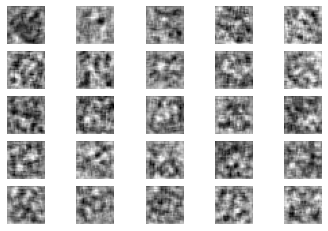

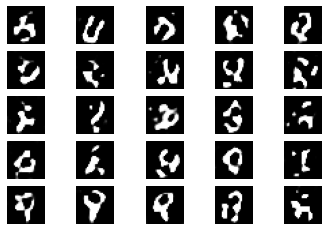

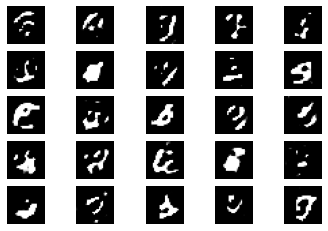

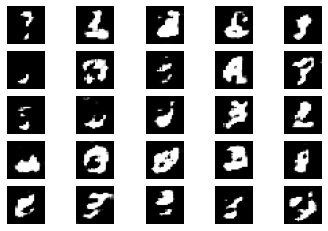

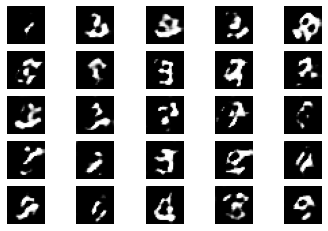

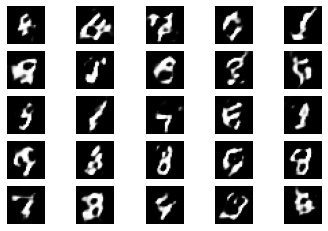

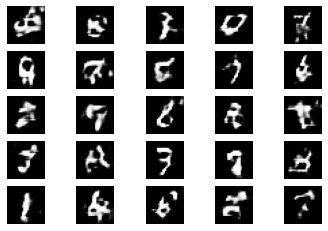

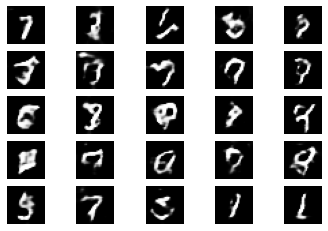

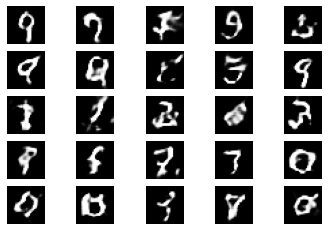

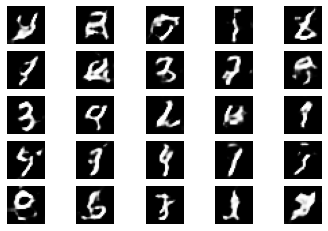

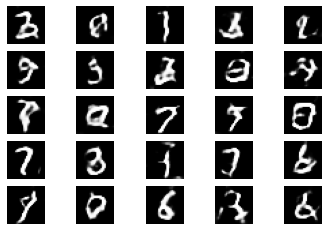

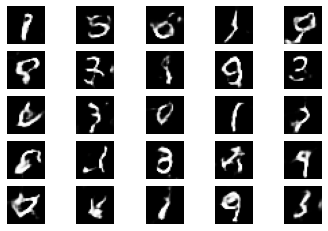

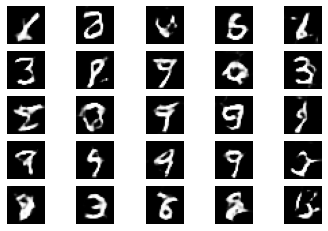

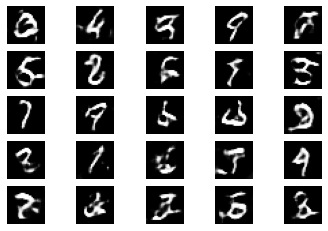

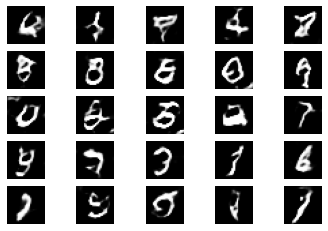

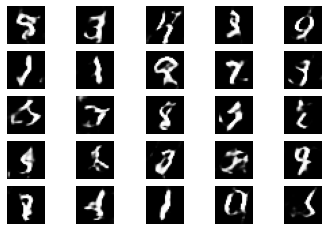

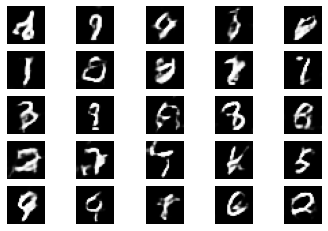

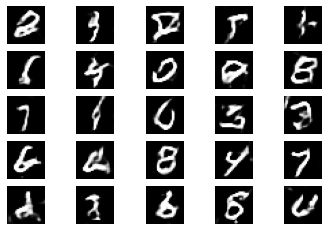

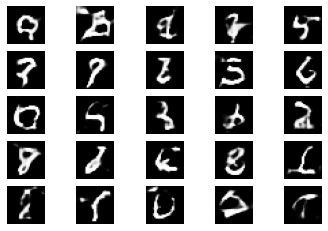

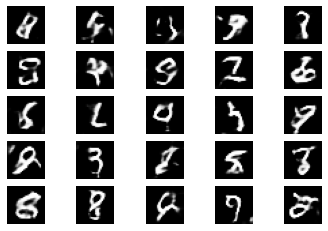

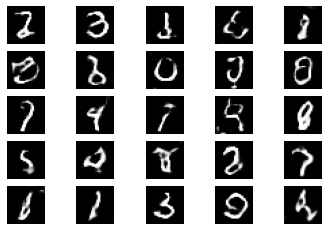

In [12]:
# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):
# MNIST 데이터 불러오기
  # 앞서 불러온 MNIST를 다시 이용, 테스트 과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 호출
  (X_train, _), (_, _) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  # 127.5를 빼준 뒤 127.5로 나눠서 -1~1사이의 값으로 바꿈
  X_train = (X_train - 127.5) / 127.5
  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    # 실제 데이터를 판별자에 입력
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    # 가상 이미지를 판별자에 입력
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    # 판별자와 생성자의 오차 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    # print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

    # 중간 과정을 이미지로 저장하는 부분. 정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에 저장하라는 뜻.
    if i % saving_interval == 0:
      # r, c = 5, 5
      noise = np.random.normal(0, 1, (25, 100))
      gen_imgs = generator.predict(noise)

      # Rescale images 0 - 1
      gen_imgs = 0.5 *gen_imgs + 0.5

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
      fig.savefig("gan_images/gan_mnist_%d.png" % i)
# 4000번 반복되고, 배치크기는 32, 200번마다 결과가 저장됨
gan_train(4001, 32, 200)